<a href="https://colab.research.google.com/github/edgeofchaos42/ComplexityExplorer/blob/main/MesaTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mesa --quiet


In [22]:
import mesa

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

# **MODEL**

In [20]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

# **Run the Model**

In [6]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

# **Results**

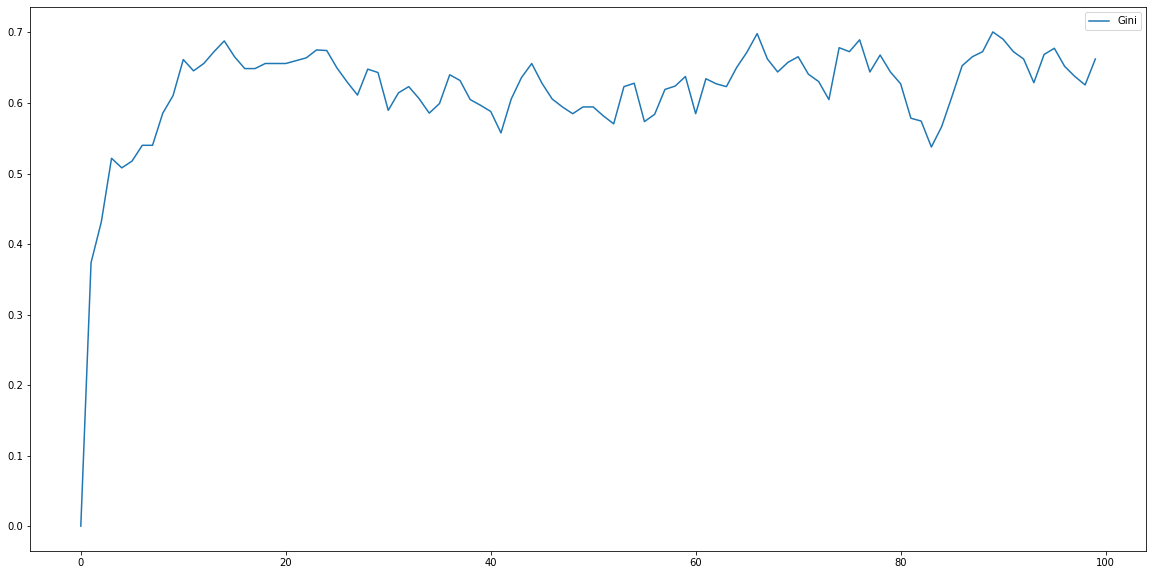

In [23]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [24]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head(10)

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1
     5             1
     6             1
     7             1
     8             1
     9             1

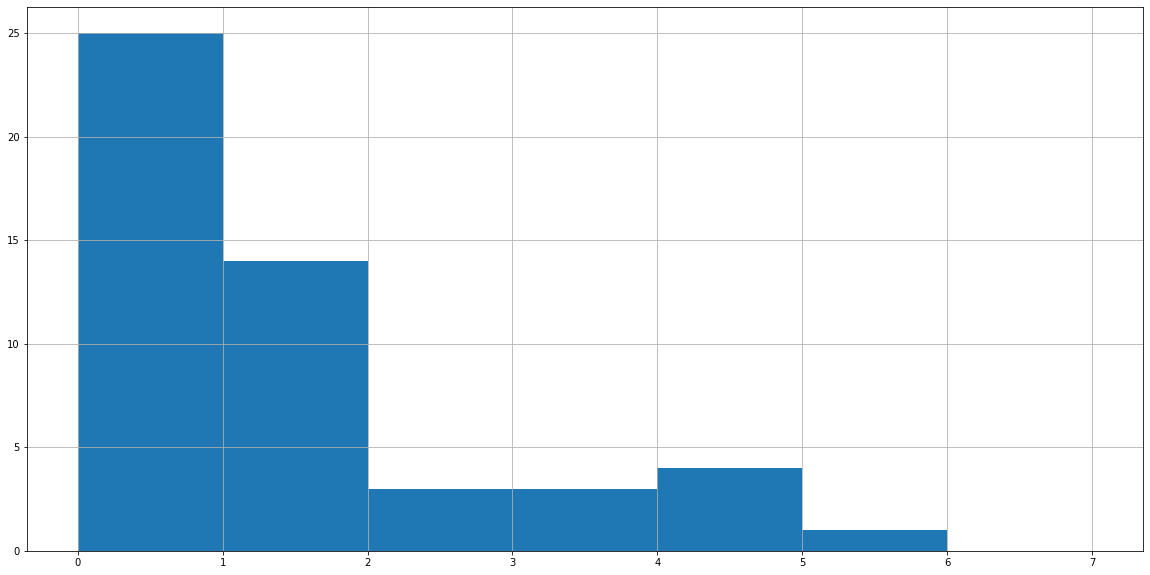

In [25]:
end_wealth = agent_wealth.xs(15, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

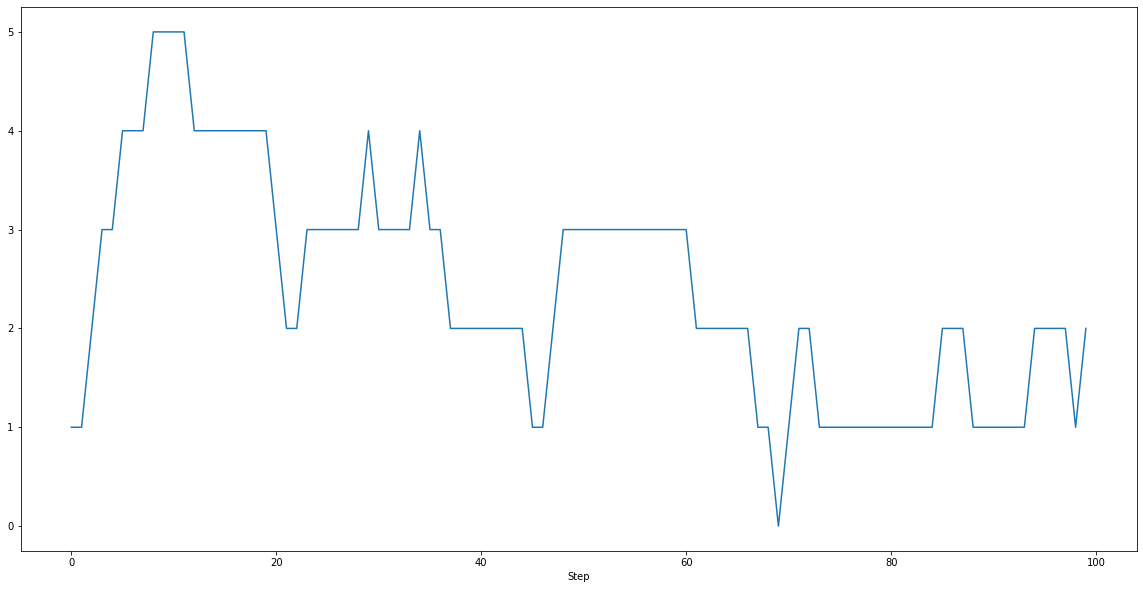

In [26]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

In [27]:
# save the model data (stored in the pandas gini object) to CSV
gini.to_csv("model_data.csv")

# save the agent data (stored in the pandas agent_wealth object) to CSV
agent_wealth.to_csv("agent_data.csv")

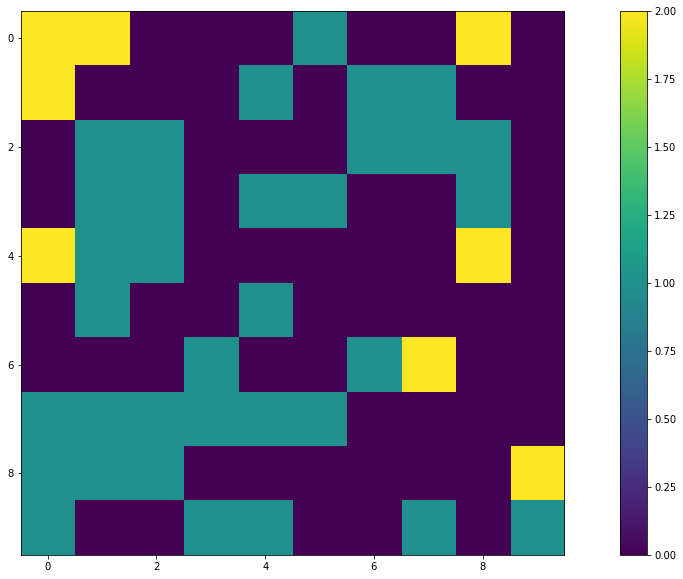

In [28]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

# **Batch Run**

In [21]:
params = {"width": 10, "height": 10, "N": range(10, 500, 10)}

results = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

245it [00:56,  4.35it/s]


# **Batch Run Results**

In [29]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Gini', 'AgentID',
       'Wealth'],
      dtype='object')


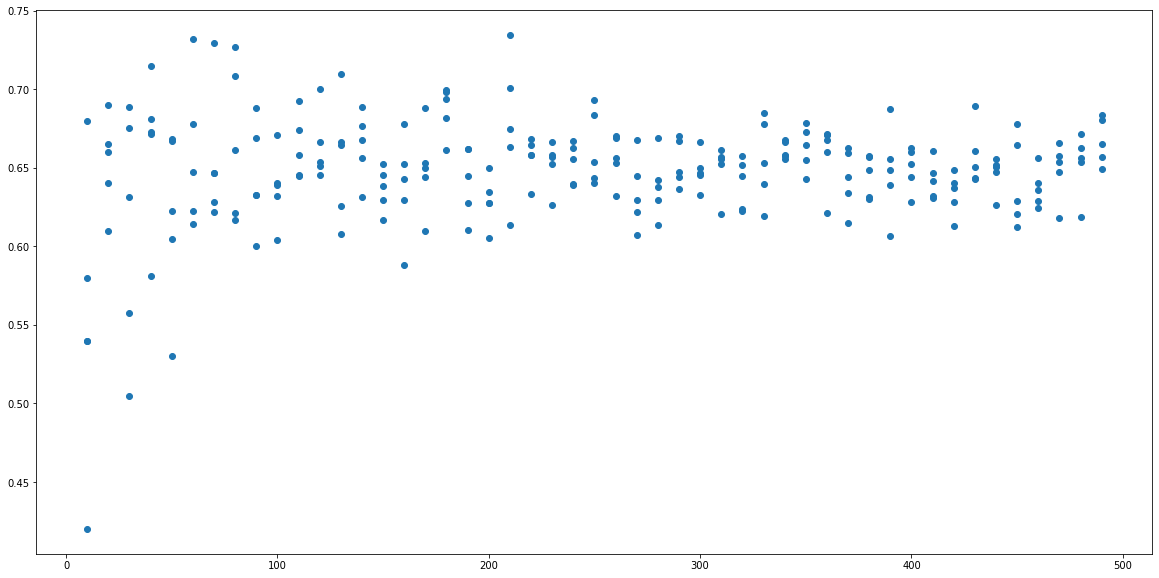

In [30]:
results_filtered = results_df[(results_df.AgentID == 0) & (results_df.Step == 100)]
N_values = results_filtered.N.values
gini_values = results_filtered.Gini.values
plt.scatter(N_values, gini_values)

In [31]:
one_episode_wealth = results_df[(results_df.N == 10) & (results_df.iteration == 2)]

print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Wealth"], max_rows=25
    )
)

 Step  AgentID  Wealth
    0        0       1
    0        1       1
    0        2       1
    0        3       1
    0        4       1
    0        5       1
    0        6       1
    0        7       1
    0        8       1
    0        9       1
    1        0       1
    1        1       1
  ...      ...     ...
   99        8       1
   99        9       2
  100        0       0
  100        1       0
  100        2       1
  100        3       1
  100        4       2
  100        5       0
  100        6       3
  100        7       0
  100        8       1
  100        9       2


In [33]:
from IPython.display import display, HTML

display(HTML(one_episode_wealth.to_html(index=False, columns=['Step', 'AgentID', 'Wealth'], max_rows=25)))

Step,AgentID,Wealth
0,0,1
0,1,1
0,2,1
0,3,1
0,4,1
0,5,1
0,6,1
0,7,1
0,8,1
0,9,1


In [34]:
results_one_episode = results_df[
    (results_df.N == 10) & (results_df.iteration == 1) & (results_df.AgentID == 0)
]
print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=25))

 Step  Gini
    0  0.00
    1  0.00
    2  0.00
    3  0.18
    4  0.18
    5  0.18
    6  0.18
    7  0.18
    8  0.18
    9  0.18
   10  0.18
   11  0.18
  ...   ...
   89  0.54
   90  0.54
   91  0.54
   92  0.54
   93  0.54
   94  0.54
   95  0.54
   96  0.62
   97  0.58
   98  0.58
   99  0.58
  100  0.58
